# Deep learning avec PyTorch

En général, l’entraînement, le choix et l’initialisation d’une architecture de deep learning sont des tâches complexes. On parle bien d’apprentissage profond, car ces architectures comportent de nombreuses couches souvent complexes.

Heureusement, PyTorch simplifie la création d’architectures grâce au module `nn`, qui fournit toutes les fonctions nécessaires pour initialiser même les architectures les plus sophistiquées.

Dans ce notebook, nous allons explorer les différentes fonctions proposées par le module `nn` et apprendre comment les utiliser pour initialiser des modèles de deep learning avec PyTorch.

## Une architecture pour résoudre le problème MNIST

Dans cette section, nous allons construire une architecture capable de résoudre le problème du jeu de données MNIST. MNIST contient des images en noir et blanc de chiffres manuscrits de 0 à 9, avec chaque image ayant une taille de 28 pixels par 28 pixels.

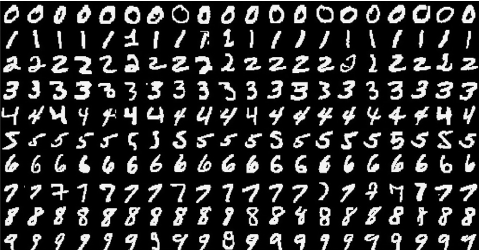

L'objectif ici est d'initialiser une architecture de deep learning capable de prendre en entrée une image du jeu de données MNIST et de prédire le chiffre manuscrit qu'elle contient.

## Importation des bibliothèques

Commençons par imorter les bibliothèques nécessaire à la résolution de notre problème.

In [1]:
import numpy as np

import torch

from torchsummary import summary

from torchvision import datasets, transforms

from collections import OrderedDict

from torch import optim

import matplotlib.pyplot as plt

## Importation des données

Nous allons maintenant importer les données MNIST.

Celles-ci sont disponibles dans le module `torchvision`.

Nous allons créer une variable `transform` pour appliquer quelques transformations aux images. Tout d’abord, nous utiliserons la fonction `ToTensor` pour convertir les images en tenseurs, puis nous appliquerons une normalisation avec la fonction `Normalize`, en utilisant une moyenne de 0.5 et un écart-type de 0.5.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

On va maintenant utiliser `DataLoader` pour créer un itérable qui va parcourir le dataset avec un *batch* de 64 et on précise que l'on veut mélanger les données à chaque nouvelle itération sur le jeu de données.

In [3]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 48.2MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.59MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.1MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Comme on peut le voir ci-dessous on obtient bien un iterable capable de parcourir notre jeu de données 64 observations par 64. L'instruction `break` me sert à quitter la boucle afin de ne pas parcourir tous le jeu de données.

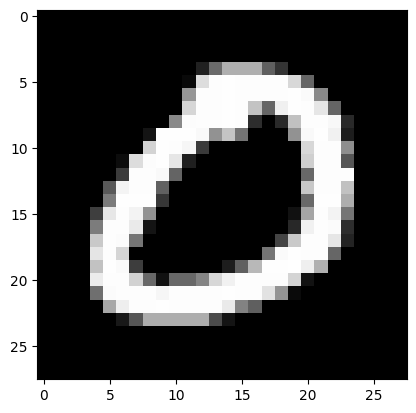

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
for image, label in trainloader:
    plt.imshow(image[1].numpy().squeeze(), cmap='Greys_r')
    plt.show()
    print(image.shape)
    print(label.shape)
    break

## Initialisation de l'architecture

On va d'abord présenter les différents éléments que nous allons utiliser dans notre architecture.

### Les couches linéaires

On va commencer par `Linear`. Cette fonction permet d'appliquer une transformation linéaire à nos données comme sur la formule ci-dessous :

$$ y = x A^T + b $$


C'est donc cette fonction qu'il faudra utiliser lorsque l'on voudra appliquer une couche de neurone fully connected.

Vous avez accès à trois paramètres :
- `in_features` sera le nombre de variables à l'entrée de la couche (nombre de neurones de la couche précédentes) ;
- `out_features` sera le nombre de variables de cette couche (nombre de variable d'entrée de la couche suivante) ;
- `bias` sera un booléan pour savoir si vous voulez entraîner un biais ou non.

Créeons une matrice d'exemple remplit avec des nombres aléatoire avec trois variables et une observation.

In [6]:
a = torch.randn([1,3])
a

tensor([[-0.8275,  0.2621,  0.4837]])

Initialisons notre couche linéaire qui prend 3 variables en entrée et qui n'a qu'un neurone donc une valeur en sortie.

In [7]:
hidden_layer = torch.nn.Linear(3,1,True)

Appliquons notre couche sur nos données.

In [8]:
hidden_layer(a)

tensor([[-0.1770]], grad_fn=<AddmmBackward0>)

On a bien un nombre en sortie de notre couche.

On peut retirer les différents poids de notre couche en utilisant les attributs `weight` et `bias`.

In [ ]:
# Your code

Le but sera d'empiler des couches linéaire pour créer notre architecture.

Mais pour le moment nous avons un modèle qui est linéaire. Pour que notre modèle soit capable de résoudre des problèmes non linéaire il faut ajouter des fonctions d'activations.

### Les fonctions d'activations

On va parler ici de celles qui seront utiles dans ce notebook, la fonction `Softmax` et la fonction `ReLU`.

La fonction `Softmax` est utiliser dans le cas de classification multi-classe comme dans le cas du jeu de données MNIST. Cette fonction d'activation est appliqué à la couche de sortie des architectures. Notre image en entrée peut être prédit dans l'une de nos 10 classes, c'est un nombre entre 0 et 9. L'expression mathématique de cette fonction est :

$$ Softmax(x_i)=\frac{exp(x_i)}{\sum_j exp(x_j)}$$

La fonction `ReLU` ou *Rectified linear unit* est utiliser pour ajouter de la non-linéarité aux modèles de deep learning. Sans cette fonction d'activation les architectures de deep learning serait des modèles linéaire pas plus puissant qu'une régression linéaire. L'expression mathématique de cette fonction est :

$$ ReLU(x) = (x)^+ = max(0,x) $$

In [ ]:
x = torch.arange(-100, 100, dtype=torch.float64)
# Utilisez la fonction Relu
y = None

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Représentation graphique de la fonction ReLU')
plt.show()

### L'empilement des couches

Nous allons maintenant voir la dernière fonction qui va nous servir à initialiser notre première architeture de deep learning en Pytorch, `Sequential`. Cette fonction va empiler les différentes couches afin d'initialiser notre architecture.

In [ ]:
a = torch.randn([1,3])

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(3, 1, True),
                            torch.nn.ReLU())

In [ ]:
model(a)

Les données d'entrée vont passer par toute les étapes initialisé dans `Sequential` jusqu'à la couche de sortie.

### Une architecture pour MNIST

On va maintenant initialiser l'architecture ci-dessous afin de résoudre le problème du jeu de données MNIST.

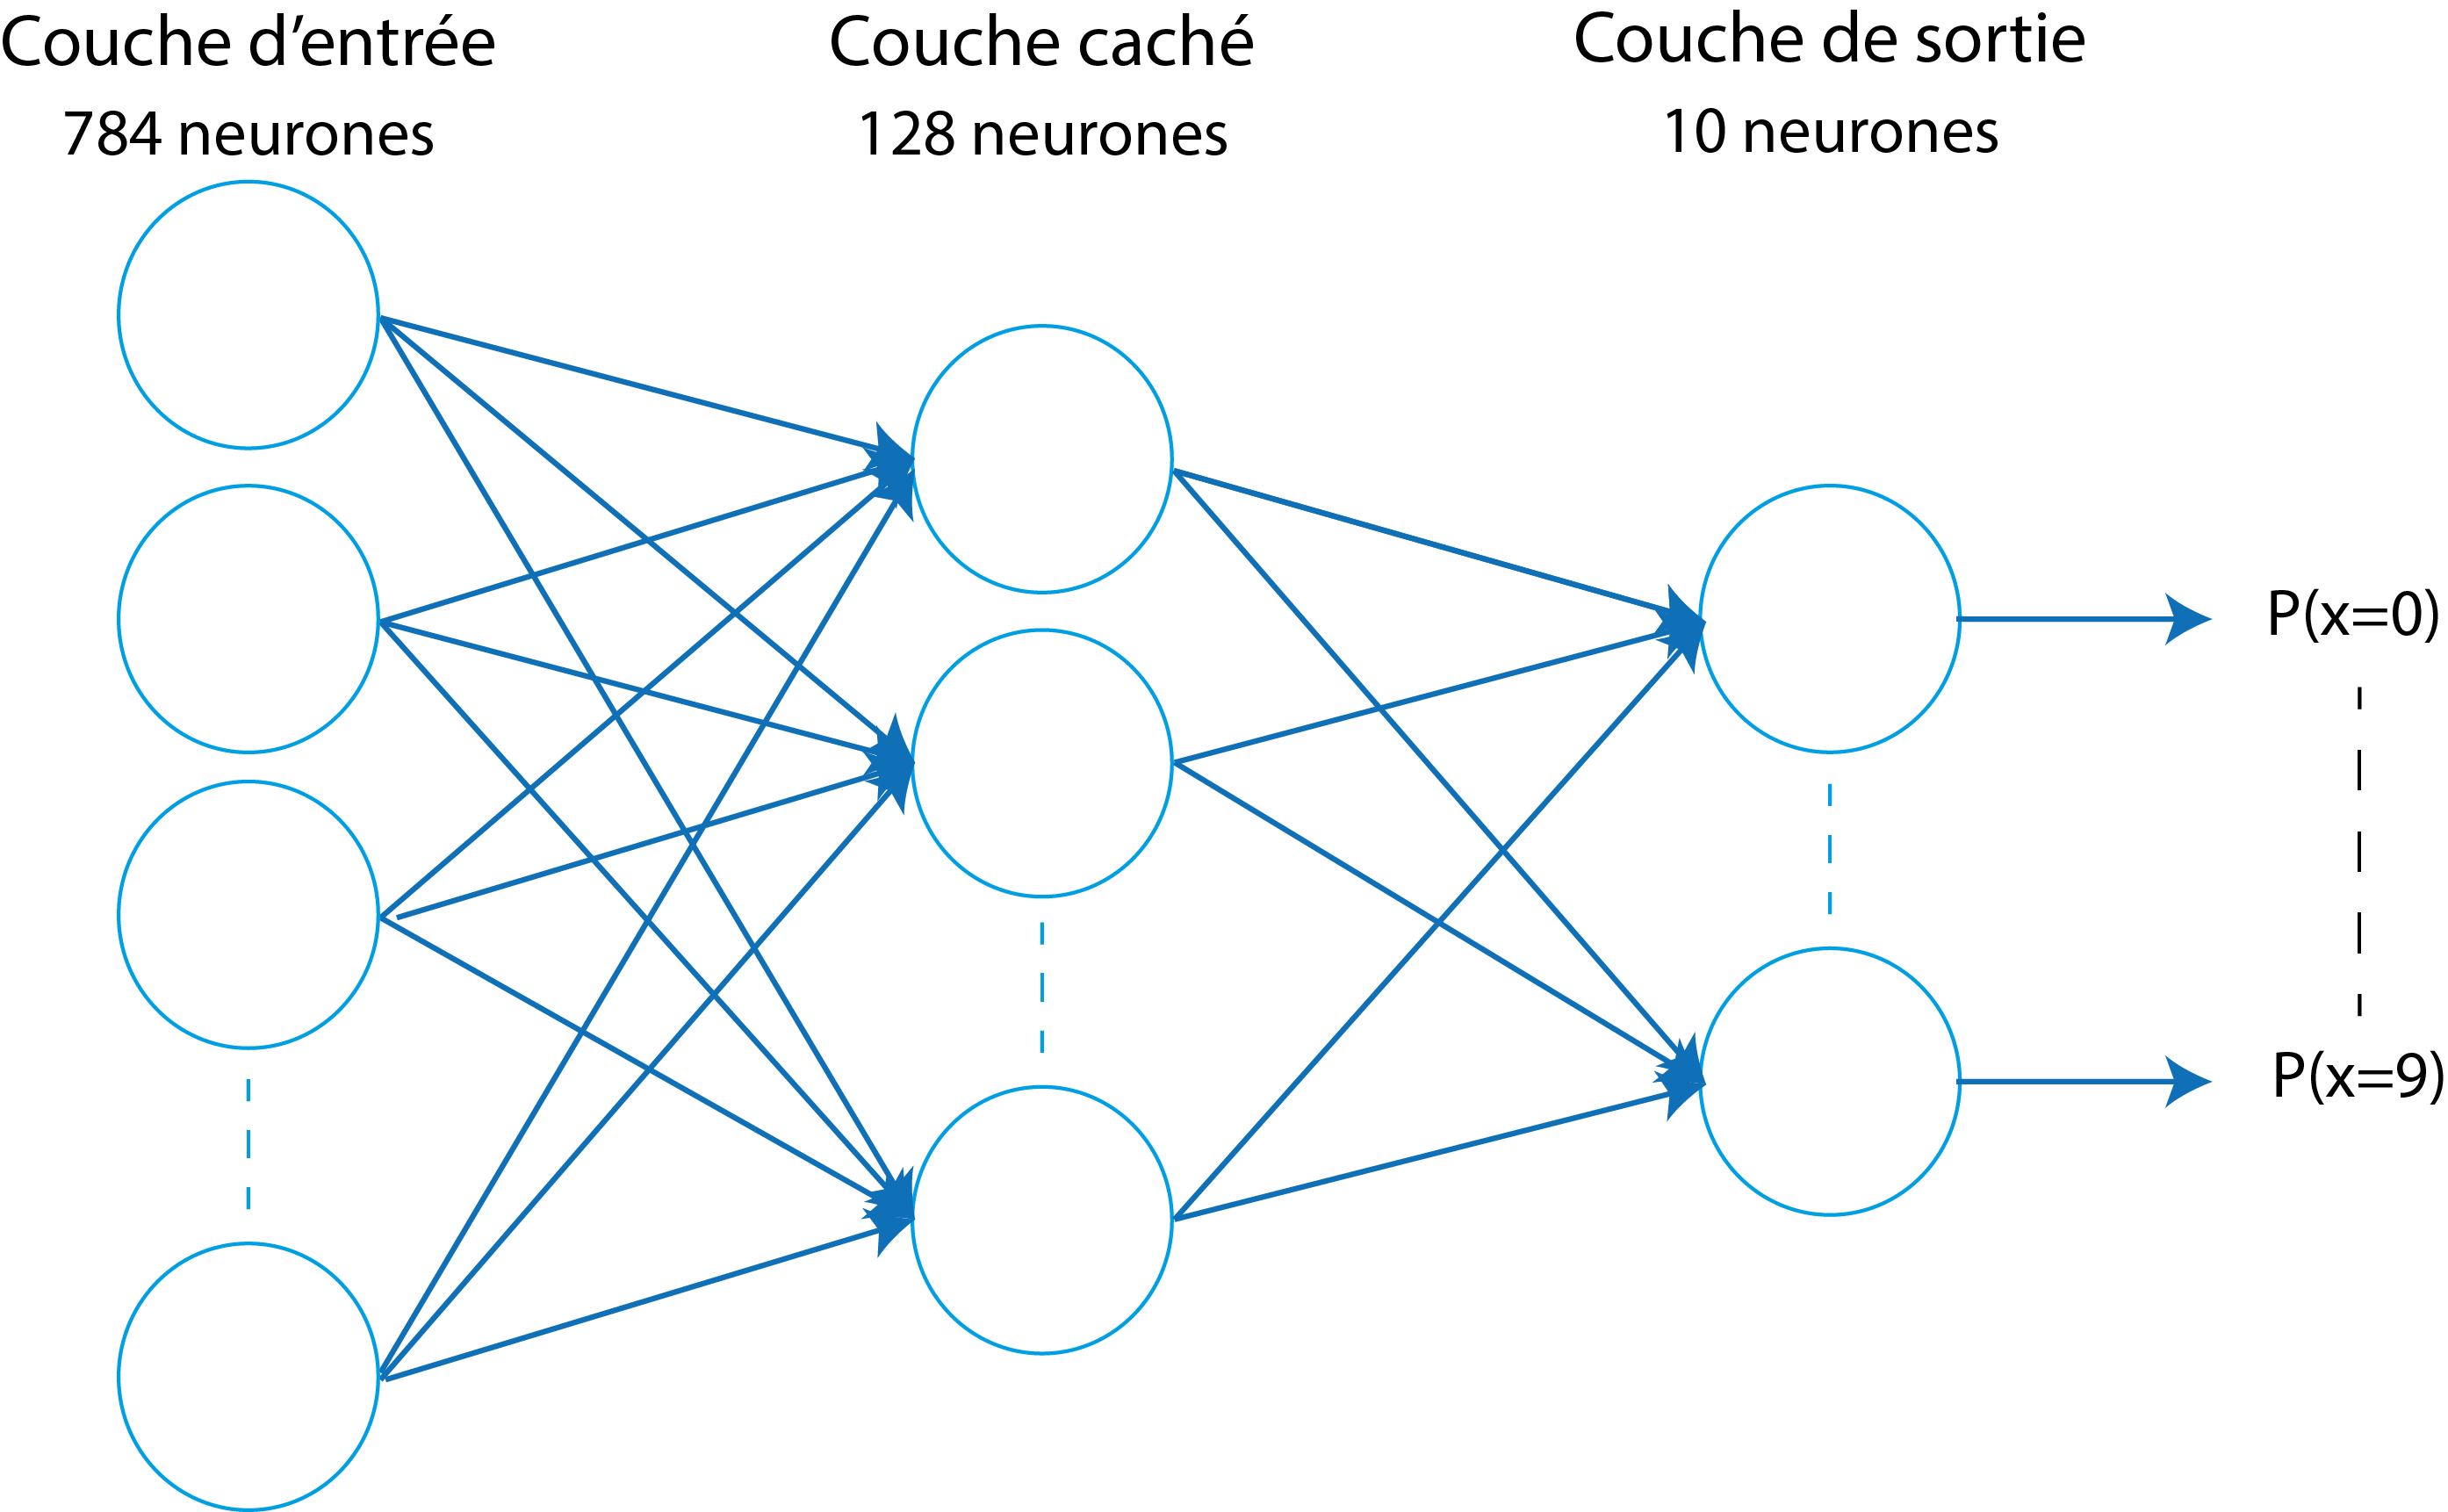

On va d'abord initialiser les hyperparamètres de notre architecture.

In [ ]:
input_size = 784
hidden_sizes = 128
output_size = 10

Initialisation de notre modèle avec les fonctions vue précédemment.

In [ ]:
model = None

On simplement visualiser le modèle tout simplement en utilisant la fonction `print`.

In [ ]:
None

Si vous voulez nommer les différentes couches de votre architecture vous pouvez utiliser la fonction `OrderedDict` comme ci-dessous.

In [ ]:
model = torch.nn.Sequential(OrderedDict([('fc1', torch.nn.Linear(input_size, hidden_sizes)),
                                         ('relu1', torch.nn.ReLU()),
                                         ('output', torch.nn.Linear(hidden_sizes, output_size)),
                                         ('softmax', torch.nn.Softmax(dim=1))]))

print(model)

Utilisez la fonction `summary` pour visualiser le modèle.

In [ ]:
None

Maintenant, effectuons une forward propagation avec un exemple.

In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

Nous avons ici un batch de 64 exemples avec leur 64 labels.

Nous allons isolé le premier exemple.

In [ ]:
image = images[0]
print(image.shape)
label = labels[0]
print(label)

Nous allons transformer nos images en vecteur contenant toutes les intensités de gris de notre image en utilisant la fonction`resize`.

In [ ]:
image.resize_(image.shape[0], 1, 784)
image.shape

Nous pouvons maintenant l'utiliser en entrée de notre modèle pour prédire la probabilité d'appartenance à nos différentes classes.

Faire une prédiction en utilisant la méthode `forward`

In [ ]:
prediction = None
print(prediction.shape)

On a bien ici un exemple avec la probabilité d'appartenance à nos différentes classes.

In [ ]:
prediction_np = prediction.data.numpy().squeeze()

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')

ax2.barh(np.arange(10), prediction_np)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

On peut voir que comme les poids du modèles sont actuellement aléatoire, il n'arrive pas à prédire la classe associé à notre image. On va donc devoir entraîner notre modèle afin qu'il puisse prédire la classe de nos images en fonction de la valeur de leur intensité.

## Entraînement d'un modèle

Maintenant il est temps d'entraîner notre jeu de données, il est temps de passer d'un modèle initialisé aléatoirement à un modèle entraîner capable d'identifier des chiffres écrits à la main sur des images.

### Appliquer une fonction de coût

La première chose à faire c'est déterminer la fonction de coût qui va permettre de savoir à quel point on se trompe dans la prédiction de notre solution.

Ici, on va pour déterminer le coût d'un problème de classification multi-classe, on va utiliser la fonction `CrossEntropyLoss` que l'on va stocker dans la variable *criterion*.

In [ ]:
criterion = None

Une fois la fonction de coût choisit on peut l'appliquer sur nos données

In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

Appliquer `model` en utilisant la méthode `forward` sur `images`.

In [ ]:
images = images.view(images.shape[0], -1)

prediction = None

Appliquer `criterion` sur les variables `prediction` et `labels`

In [ ]:
loss = None
print(loss)

### Calculer les gradients

On va calculer les gradents par rapport à notre erreur afin de mettre à jour les poids de notre modèle. Le but étant d'optimiser les poids afin de faire converger notre erreur vers 0.

La fonction `backward` de PyTorch permet de calculer automatiquement les gradients qu'importe le graph de calcul que vous avez créé.

Imaginons nous avons une matrice de poids *w_1* qui va être multiplier par nos données *x_1*.

On spécifie bien `requires_grad=True` pour les poids.

In [ ]:
w_1 = torch.randn([2, 1], dtype=float, requires_grad=True)
x_1 = torch.randn([5, 2], dtype=float)
y = torch.randn([5, 1], dtype=float)

h = torch.mm(x_1, w_1)
print(h.shape)

Calculons l'erreur de prédiction qui est l'écart entre *y* et *h*.

In [ ]:
error = torch.mean(h-y)
print(error)

On va maintenant calculer les gradients de nos poids *w_1*

In [ ]:
print(w_1.grad)
error.backward()
print(w_1.grad)

On peut voir que les gradients on été initiliasé à *None*, c'est seulement après l'utilisation de la fonction `backward` que les gradients sont calculés.

Pour le calcul de nos poids précédemment ça donne ça.

In [ ]:
print(model[0].weight.grad)
loss.backward()
print(model[0].weight.grad)

### Optimiser vos poids

Maintenant que vous avez calculé vos gradients il va falloir mettre à jour vos poids. Il existe de nombreux algorithmes d'optimisation, ici on va rester simple en utilisant celui du Stochastic Gradient Descent `SGD`.

On va d'abord initialiser notre algorithme d'optimisation et choisir le pas d'apprentissage (learning rate).

In [ ]:
optimizer = None

In [ ]:
print(model[0].weight)

In [ ]:
print(model[0].weight.grad)

Utilisez la méthohde `step` de `optimizer` pour mettre à jour les paramètres du modèle.

In [ ]:
None

In [ ]:
print(model[0].weight)

## Définir la fonction d'entraînement

Vous allez maintenant initialiser la fonction d'entraînement du modèle en utilisant le modèle, la fonction de coût et l'algorithme d'optimisation précédemment initialisé.

In [ ]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         loss:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  None

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = None

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = None

  # Calculez les gradients avec la méthode 'backward'
  None

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  None

  return model, loss

## Entraîner le modèle

Initialisez `model` avec `Sequential` en utilisant la même architecture que précédemment.

Initialisez `cirterion` avec `NLLLoss`

Initialisez `optimizer` avec `SGD` avec un learning rate de 0.003

In [ ]:
model = None

criterion = None

optimizer = None

Il est maintenant temps d'entraîner le modèle



In [ ]:
epoch = 5
history_train = []

for e in range(epoch) :


  running_loss = 0

  for images, labels in trainloader:

    images = images.view(images.shape[0], -1)

    # mise à jour des poids avec la fonction 'step'
    model, train_loss = None

    # Sauvegarde des coûts d'entraînement avec append
    history_train = None

  print('train_loss : '+str(np.squeeze(train_loss.detach().numpy())))


Visualisation de l'évolution du coût pendant l'entraînement.

In [ ]:
plt.plot(np.arange(epoch), history_train, label='train loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Voyons après 5 itérations si notre modèle arrive à prédire une image de notre jeu de données.

In [ ]:
images, labels = next(iter(trainloader))
image = images[0]
label = labels[0]

img = images[0].view(1, 784)

logps = model.forward(img)
prediction = torch.exp(logps)

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

ax1.imshow(images[0].resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')

ax2.barh(np.arange(10), prediction.data.numpy().squeeze())
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

Fécilications, vous avez entraîner votre premier modèle de deep learning en utilisant PyTorch.